In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [2]:
root_path = '../input/isic-2019'


In [3]:
IMAGE_DIR = os.path.join(root_path, 'ISIC_2019_Training_Input/ISIC_2019_Training_Input')
panda_path = os.path.join(root_path, 'ISIC_2019_Training_GroundTruth.csv')

In [4]:
print(len(os.listdir(IMAGE_DIR)))


25333


In [5]:
print(f'This is the image dir: {IMAGE_DIR}')
print(f'This is the csv filepath: {panda_path}')

This is the image dir: ../input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input
This is the csv filepath: ../input/isic-2019/ISIC_2019_Training_GroundTruth.csv


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt

In [7]:
def preprocess(df):
    for index, img in enumerate(df.image):
        img = img+'.jpg'
        df.image[index]=img
    df.drop(['UNK'], axis=1, inplace=True)

In [8]:
def train_val_test_split(df, test_len=1000, val_ratio=0.2):
    test_rows = (np.random.rand(1000)*df.shape[0]).astype(int)
    test_df =  df.iloc[test_rows]
    test_df = test_df.reset_index().drop(['index'], axis=1)
    df.drop(test_rows, axis=0, inplace=True)
    df = df.reset_index().drop(['index'], axis=1)
    val_rows = (np.random.rand(int(val_ratio*df.shape[0]))*df.shape[0]).astype(int)
    val_df = df.iloc[val_rows]
    df.drop(val_rows, axis=0, inplace=True)
    val_df = val_df.reset_index().drop(['index'], axis=1)
    test_df = test_df.reset_index().drop(['index'], axis=1)
    df = df.reset_index().drop(['index'], axis=1)
#     int_dict = {'MEL':int, 'NV':int, 'BCC':int, 'AK':int, 'BKL':int, 'DF':int, 'VASC':int, 'SCC':int}
#     df = df.astype(int_dict) 
#     val_df = val_df.astype(int_dict)
#     test_df = test_df.astype(int_dict)
    return df, val_df, test_df

In [9]:
full_df = pd.read_csv(panda_path)
preprocess(full_df)
train_df, val_df, test_df = train_val_test_split(full_df)
labels=list(train_df.columns[1:])
print(labels)
train_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC
0,ISIC_0000000.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000004.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000007.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
def compute_class_freqs(labels):

    N = labels.shape[0]
    
    positive_frequencies = np.mean(labels, axis=0)
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [11]:
labels = list(train_df.columns)[1:]

In [12]:
def get_test_and_valid_generator(valid_df=val_df, test_df=test_df, train_df=train_df, image_dir=IMAGE_DIR, x_col='image', y_cols=labels, sample_size=100, batch_size=32, seed=42, target_w = 320, target_h = 320):

    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="image", 
        y_col=y_cols, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [13]:

def get_train_generator(df=train_df, image_dir=IMAGE_DIR, x_col='image', y_cols=labels, shuffle=True, batch_size=32, seed=42, target_w = 320, target_h = 320):
    
    
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [14]:
train_generator = get_train_generator()
valid_generator, test_generator= get_test_and_valid_generator()

getting train generator...
Found 19958 validated image filenames.
getting train and valid generators...
Found 19958 validated image filenames.
Found 4870 validated image filenames.
Found 1000 validated image filenames.


(32, 320, 320, 3)
(32, 8)


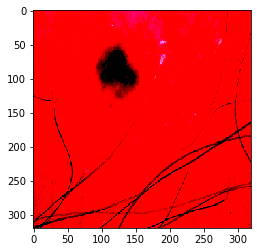

In [15]:
x, y = train_generator.__getitem__(0)
print(x.shape)
print(y.shape)
plt.imshow(x[2]);


In [16]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)

pos_weights = freq_neg
neg_weights = freq_pos

In [17]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    
    def weighted_loss(y_true, y_pred):
        
        # initialize loss to zero
        loss = 0.0
        

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += K.mean(-(pos_weights[i]*y_true[:, i]*K.log(y_pred[:, i]+epsilon)
                             + neg_weights[i]*(1-y_true[:, i])*K.log((1-y_pred[:, i])+epsilon)))
        return loss
    
    return weighted_loss

In [18]:
from keras import backend as K
base_model = DenseNet121(weights='imagenet', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights), metrics=['accuracy'])

Using TensorFlow backend.


29089792/29084464 [==============================] - 2s 0us/step


In [19]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator,
                        validation_steps=STEP_SIZE_VALID, epochs=5)

Train for 623 steps, validate for 152 steps
Epoch 1/5
623/623 [==============================] - 1348s 2s/step - loss: 0.6881 - accuracy: 0.5081 - val_loss: 0.8585 - val_accuracy: 0.4698
Epoch 2/5
623/623 [==============================] - 1093s 2s/step - loss: 0.6013 - accuracy: 0.5767 - val_loss: 1.0238 - val_accuracy: 0.4093
Epoch 3/5
623/623 [==============================] - 1066s 2s/step - loss: 0.5574 - accuracy: 0.6149 - val_loss: 0.6568 - val_accuracy: 0.4870
Epoch 4/5
623/623 [==============================] - 1061s 2s/step - loss: 0.5220 - accuracy: 0.6352 - val_loss: 0.5888 - val_accuracy: 0.5711
Epoch 5/5
623/623 [==============================] - 1107s 2s/step - loss: 0.4884 - accuracy: 0.6643 - val_loss: 0.5792 - val_accuracy: 0.6007


In [41]:
model.save('best_model.h5')

In [34]:
predicted_vals = model.predict_generator(valid_generator, steps = len(valid_generator))

In [35]:
#copied from Coursera util package
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity
import cv2

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

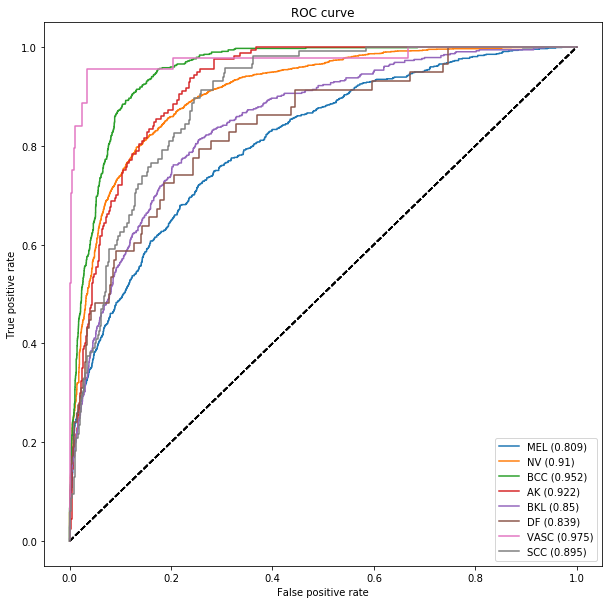

In [36]:
auc_rocs = get_roc_curve(labels, predicted_vals, valid_generator)

In [37]:
y_true, y_pred = [], []
for pred, arr in zip(predicted_vals, test_generator.labels):
    y_true.append(np.argmax(arr))
    y_pred.append(np.argmax(pred))
y_true = np.array(y_true)
y_pred = np.array(y_pred)
print("y_true:", y_true)
print("y_pred:", y_pred)

y_true: [2 4 4 4 1 1 4 1 1 3 1 0 5 1 1 1 1 0 1 1 0 1 1 3 0 2 0 0 1 1 0 2 1 1 1 1 7
 1 7 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 7 1 1 4 7 1 7 1 2 0 6 1 1 1 4 4 1 1 1 1
 1 0 7 3 1 1 1 2 1 2 1 1 1 4 3 4 1 1 1 3 0 1 1 1 4 2 1 1 3 7 1 1 1 5 4 7 1
 1 1 4 4 1 0 4 0 1 1 1 7 1 1 1 1 4 1 0 0 1 1 1 2 1 1 1 1 1 4 1 2 4 0 1 2 0
 1 1 1 0 0 1 1 4 1 1 1 1 0 2 2 3 4 1 1 2 4 3 0 1 1 1 1 1 1 1 1 4 1 1 1 1 1
 1 1 1 0 0 1 0 2 1 1 0 1 4 1 1 3 1 1 2 1 0 7 1 1 1 1 2 0 1 1 0 1 1 1 0 0 1
 0 1 0 1 1 1 1 0 0 2 1 1 2 2 1 1 0 0 1 0 1 0 1 0 1 1 1 2 6 4 1 0 1 2 1 7 1
 1 0 1 1 1 0 1 5 0 2 2 6 1 2 1 1 4 0 1 5 1 4 1 1 1 1 1 1 0 1 1 1 1 4 1 1 1
 1 1 3 2 2 1 1 1 0 1 0 1 0 3 1 1 1 1 0 1 0 1 2 1 1 0 1 2 1 1 5 4 1 1 0 1 1
 1 1 0 2 1 1 1 0 2 1 4 1 4 1 2 1 4 0 4 1 2 1 1 1 1 1 6 1 1 1 0 1 4 1 4 2 1
 0 1 0 1 3 3 0 2 0 0 1 0 0 1 0 1 4 2 1 7 0 0 2 1 0 1 1 0 0 1 1 4 1 1 1 1 1
 0 4 1 1 1 2 1 2 1 6 1 1 2 1 0 1 2 1 1 0 1 2 0 1 0 1 1 1 3 0 2 1 4 1 0 4 0
 4 2 2 1 0 2 1 1 0 2 2 4 2 1 3 4 1 0 1 4 0 1 1 4 1 1 0 1 2 1 0 1 1 4 2 1 4
 1 0 1 1 0 4 0 1 

In [38]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
   
   
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [39]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, y_pred, labels=range(8))
conf_mat

array([[ 15,  84,  20,   6,  35,   8,  19,   3],
       [ 24, 239,  78,  17,  98,  27,  47,   5],
       [  4,  48,  13,   1,  30,   1,   9,   5],
       [  3,   8,   5,   0,   4,   2,   5,   1],
       [  5,  39,  15,   2,  15,  10,   2,   4],
       [  1,   2,   1,   0,   2,   0,   2,   0],
       [  1,   5,   1,   0,   2,   0,   1,   0],
       [  0,  15,   4,   1,   5,   0,   1,   0]])

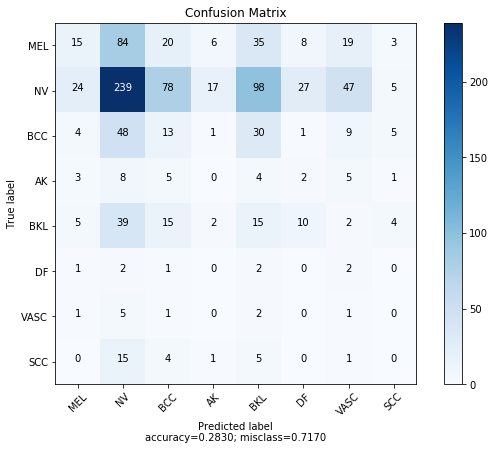

In [42]:
plot_confusion_matrix(cm           = conf_mat, 
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix")
